### Dependencies

In [1]:
!pip install matplotlib tensorflow tensorflow_addons tensorflow_datasets imageio

### Setup

In [127]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from tensorflow.keras import Model
import tensorflow as tf

from IPython import display

### Dataset

In [174]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
# train_images = tf.image.resize(train_images, (32,32)) # if we want to resize 
train_images = tf.expand_dims(train_images, -1)
train_images = tf.image.resize(train_images, (32,32))
train_images.shape

TensorShape([60000, 32, 32, 1])

#### Note: 

Non-grayscale image should be normalized to [-1,1]

In [129]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [104]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### Generator network

#### Note:

Modify the network size for deployment

In [105]:
class Generator(Model):

    def __init__(self, noise_dim, image_shape, num_channel):
        super().__init__()
        
        assert len(image_shape) == 2
        assert image_shape[0]%8 == 0
        assert image_shape[1]%8 == 0
        
        self.noise_dim = noise_dim
        self.image_shape = image_shape
        self.num_channel = num_channel
        self.kernel_size = int(min(max(min(image_shape[0]/8.0-3.0, image_shape[1]/8.0-3.0), 3.0), 11.0))

        self.b_norm_d = layers.BatchNormalization()
        self.b_norm_c1 = layers.BatchNormalization()
        self.b_norm_c2 = layers.BatchNormalization()
        self.b_norm_c3 = layers.BatchNormalization()
        self.lr_d = layers.LeakyReLU()
        self.lr_c1 = layers.LeakyReLU()
        self.lr_c2 = layers.LeakyReLU()
        self.lr_c3 = layers.LeakyReLU()
        
        self.init_dense = layers.Dense(image_shape[0]/8.0*image_shape[1]/8.0*64,
                               use_bias=False, input_shape=(self.noise_dim,))
        
        self.init_reshape = layers.Reshape((int(image_shape[0]/8.0), int(image_shape[1]/8.0), 64))
        
        self.conv2dT1 = layers.Conv2DTranspose(32, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same', use_bias=False)
        self.conv2dT2 = layers.Conv2DTranspose(16, (self.kernel_size, self.kernel_size),
                                               strides=(2, 2), padding='same', use_bias=False)
        self.conv2dT3 = layers.Conv2DTranspose(8, (self.kernel_size, self.kernel_size),
                                               strides=(2, 2), padding='same', use_bias=False)
        self.conv2dTactv = layers.Conv2DTranspose(self.num_channel, (self.kernel_size, self.kernel_size),
                                               strides=(2, 2), padding='same', use_bias=False, activation='tanh')

    def call(self, noise_vec):

        init_vec = self.lr_d(self.b_norm_d(self.init_dense(noise_vec)))
        
        reshaped = self.init_reshape(init_vec)
        
        convt1 = self.lr_c1(self.b_norm_c1(self.conv2dT1(reshaped)))
        
        convt2 = self.lr_c2(self.b_norm_c2(self.conv2dT2(convt1)))
                         
        convt3 = self.lr_c3(self.b_norm_c3(self.conv2dT3(convt2)))
            
        out = self.conv2dTactv(convt3)

        return out

#### Testing

In [106]:
g1 = Generator(10, (32, 32), 1)

In [107]:
g1.kernel_size

3

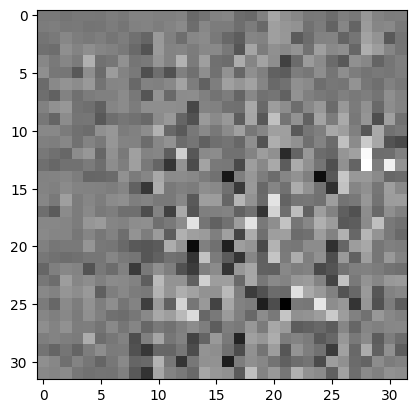

In [108]:
noise_input = np.random.normal(loc=0.0, scale=1.0, size=10)
pic1 = g1(tf.expand_dims(noise_input, 0))
plt.imshow(pic1[0, :, :, 0], cmap='gray')

In [109]:
g1.summary()

Model: "generator_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_43 (Bat  multiple                 4096      
 chNormalization)                                                
                                                                 
 batch_normalization_44 (Bat  multiple                 128       
 chNormalization)                                                
                                                                 
 batch_normalization_45 (Bat  multiple                 64        
 chNormalization)                                                
                                                                 
 batch_normalization_46 (Bat  multiple                 32        
 chNormalization)                                                
                                                                 
 leaky_re_lu_42 (LeakyReLU)  multiple                 

### Discriminator

In [146]:
class Discriminator(Model):

    def __init__(self, image_shape, num_channel):
        super().__init__()
        
        assert len(image_shape) == 2
        assert image_shape[0]%8 == 0
        assert image_shape[1]%8 == 0
        
        self.image_shape = image_shape
        self.num_channel = num_channel
        self.kernel_size = int(min(max(min(image_shape[0]/8.0-3.0, image_shape[1]/8.0-3.0), 3.0), 11.0))

        self.b_norm_c1 = layers.BatchNormalization()
        self.b_norm_c2 = layers.BatchNormalization()
        self.b_norm_c3 = layers.BatchNormalization()
        self.lr_c1 = layers.LeakyReLU()
        self.lr_c2 = layers.LeakyReLU()
        self.lr_c3 = layers.LeakyReLU()
        self.flatten = layers.Flatten()
        self.do_c1 = layers.Dropout(0.3)
        self.do_c2 = layers.Dropout(0.3)
        self.do_c3 = layers.Dropout(0.3)
        
        self.conv2d1 = layers.Conv2D(32, (self.kernel_size, self.kernel_size),
                                               strides=(2, 2), padding='same',
                                        input_shape=(None, self.image_shape[0], self.image_shape[1], self.num_channel))
        self.conv2d2 = layers.Conv2D(64, (self.kernel_size, self.kernel_size),
                                               strides=(2, 2), padding='same')
        self.conv2d3 = layers.Conv2D(128, (self.kernel_size, self.kernel_size),
                                               strides=(2, 2), padding='same')
        self.dense_actv = layers.Dense(1)
        
    def call(self, img_input):
        
        conv1 = self.do_c1(self.lr_c1(self.b_norm_c1(self.conv2d1(img_input))))
        
        conv2 = self.do_c1(self.lr_c2(self.b_norm_c2(self.conv2d2(conv1))))
                         
        conv3 = self.do_c1(self.lr_c3(self.b_norm_c3(self.conv2d3(conv2))))
        
        flat = self.flatten(conv3)
        
        out = self.dense_actv(flat)

        return out

#### Testing

In [147]:
d1 = Discriminator((32,32),1)
g2 = Generator(10, (32,32), 1)

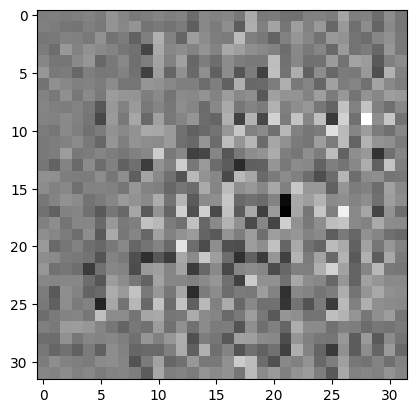

In [148]:
noise_input = np.random.normal(loc=0.0, scale=1.0, size=10)
pic2 = g1(tf.expand_dims(noise_input, 0))
plt.imshow(pic2[0, :, :, 0], cmap='gray')

In [162]:
deci = d1(tf.squeeze(tf.convert_to_tensor([pic1,pic2]), axis=1))
deci

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[0.00117456],
       [0.00025797]], dtype=float32)>

### DCGAN

In [173]:
class DCGAN:
    
    def __init__(self, dataset, image_shape, num_channel, noise_latent_dim, buffer_size=60000, batch_size=256, lr=3e-4):
        assert len(image_shape) == 2
        assert image_shape[0]%8 == 0
        assert image_shape[1]%8 == 0
        assert len(dataset.shape) == 4
        self.image_shape = image_shape
        self.num_channel = num_channel
        self.noise_latent_dim = noise_latent_dim
        self.buffer_cap, self.batch_size = buffer_size, batch_size
        self.num_img_prog_monit = 16
        
        self.dataset = tf.data.Dataset.from_tensor_slices(tf.image.resize(dataset,
                                                                          self.image_shape)).shuffle(self.buffer_cap).batch(self.batch_size)
        # NOTE: Dataset must be processed differently for different source and applications
        
        self.d = Discriminator(self.image_shape, self.num_channel)
        self.g = Generator(self.noise_latent_dim, self.image_shape, self.num_channel)
        
        self.g_opt = tf.keras.optimizers.Adam(lr)
        self.d_opt = tf.keras.optimizers.Adam(lr)
        
        self.cross_ent = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        # MUST be reimplemented with cramer's loss, TEMPORARY
        
        self.g_seed = tf.random.normal((self.num_img_prog_monit, self.noise_latent_dim))
        
    def d_loss(self, d_x_data, d_g_z):
        x_loss = self.cross_ent(tf.ones_like(d_x_data), d_x_data)
        g_loss = self.cross_ent(tf.zeros_like(d_g_z), d_g_z)
        
        return x_loss + g_loss
        
    def g_loss(self, d_g_z):
        return self.cross_ent(tf.ones_like(d_g_z), d_g_z)
    
    @tf.function
    def update(self, img):
        noise_input = tf.random.normal((self.batch_size, self.noise_latent_dim))
        
        with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
            g_z = self.g(noise_input, training=True)
            
            d_x_data = self.d(img, training=True)
            d_g_z = self.d(g_z, training=True)
            
            g_loss = self.g_loss(d_g_z)
            d_loss = self.d_loss(d_x_data, d_g_z)
        grad_g = g_tape.gradient(g_loss, self.g.trainable_variables)
        grad_d = d_tape.gradient(d_loss, self.d.trainable_variables)
        
        self.g_opt.apply_gradients(zip(grad_g, self.g.trainable_variables))
        self.d_opt.apply_gradients(zip(grad_d, self.d.trainable_variables))
        
    def train(self, epochs=50):
        for epo in range(epochs):
            for img_b in self.dataset:
                self.update(img_b)
                
            self.monitor_progress()
            
    def monitor_progress(self):
        pics = self.g(self.g_seed)
        
        fig = plt.figure(figsize=(4,4))
        for i in range(pics.shape[0]):
            plt.subplot(4,4,i+1)
            plt.imshow(pics[i,:,:,0]*127.5+127.5,cmap='gray')
            plt.axis('off')

        
        plt.show()
        
        
        
        
        

#### Testing

In [175]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = tf.expand_dims(train_images, -1)

In [176]:
dcgan1 = DCGAN(train_images, (32,32), 1, 10)

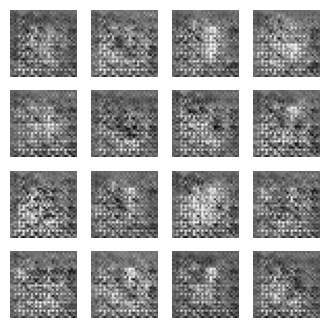

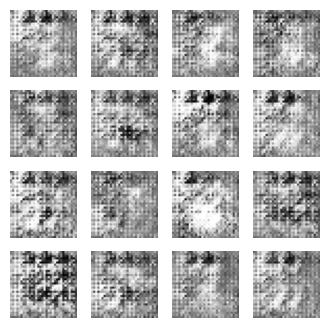

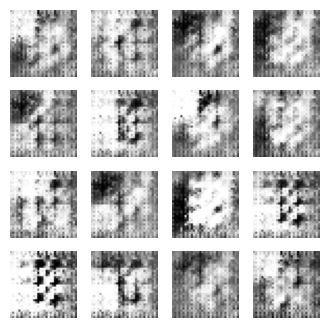

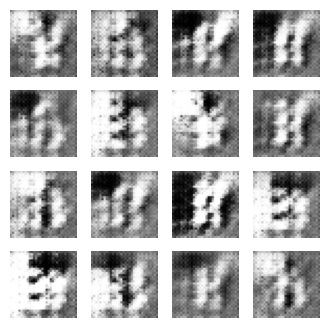

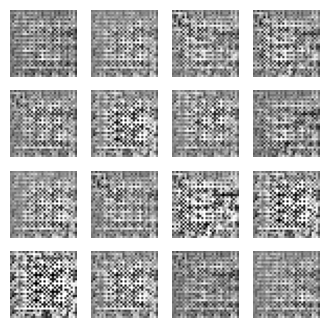

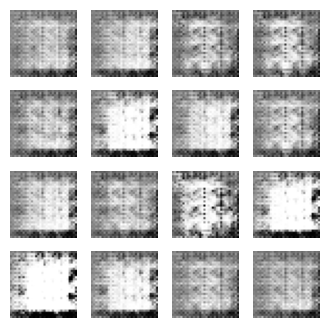

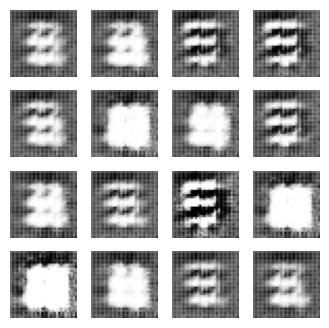

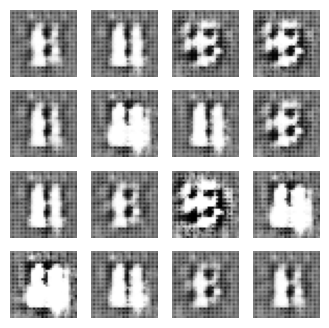

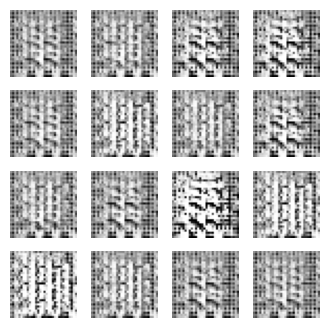

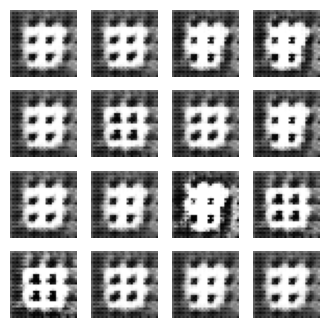

In [177]:
dcgan1.train(10)